# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\LiGht\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:44<00:00, 1956.78it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import datasets
final['CleanedText']=preprocessed_reviews
print(final.shape)

(87773, 11)


In [25]:
labels = final['Score'].values

X = final['CleanedText'].values
Y = labels[0:100000]

In [26]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train)
# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vect.transform(X_train)
X_cv_bow = vect.transform(X_cv)
X_test_bow = vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100) 


After vectorizations
(39400, 37198) (39400,)
(19407, 37198) (19407,)
(28966, 37198) (28966,)


In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
alphas=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clf=SGDClassifier(loss='hinge', penalty='l2')
param_grid={'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(X_train_bow, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
    

best alpha =  {'alpha': 0.001}
Accuracy on train data =  90.8274111675127


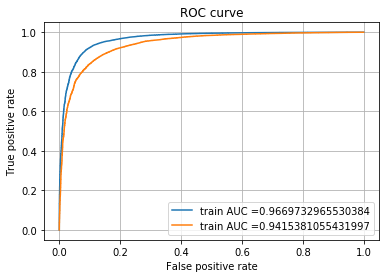

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC


clf=SGDClassifier(loss='hinge', penalty='l2',alpha=0.001)
svm=CalibratedClassifierCV(clf, cv=3) #calibrated classifier cv for calculation of predic_proba
svm.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svm.predict_proba(X_train_bow)[:,1]
y_test_pred = svm.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [34]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [35]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8311735334364824 for threshold 0.801
Train confusion matrix
[[ 5854   598]
 [ 2765 30183]]
Test confusion matrix
[[ 3940   685]
 [ 2673 21668]]


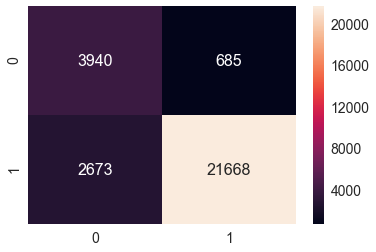

In [36]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g') 

In [44]:
#top 10 positive features
all_features = vect.get_feature_names()
clf=SGDClassifier(alpha=0.1)
clf.fit(X_train_bow,y_train)
weight=clf.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
love
good
best
delicious
loves
favorite
perfect
nice
find


In [45]:
#top 10 negative features
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
bad
not
disappointed
money
horrible
waste
awful
terrible
even
return


# [5.1.2] Applying Linear SVM on tfidf,<font color='red'> SET 2</font>

In [46]:
# Please write all the code with proper documentation
#splitting
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(39400, 23467) (39400,)
(19407, 23467) (19407,)
(28966, 23467) (28966,)


In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
alphas=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clf1=SGDClassifier(loss='hinge', penalty='l2')
param_grid={'alpha':alphas}
grid = GridSearchCV(estimator = clf1,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(X_train_tfidf, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 0.0001}
Accuracy on train data =  91.24619289340102


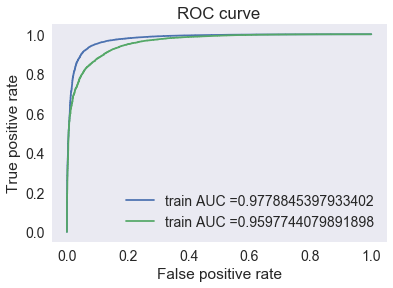

In [72]:
from sklearn.metrics import roc_curve, auc


clf1=SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001)
svm=CalibratedClassifierCV(clf1, cv=3) #calibrated classifier cv for calculation of predic_proba
svm.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svm.predict_proba(X_train_tfidf)[:,1]
y_test_pred = svm.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [73]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8670950132697028 for threshold 0.825
Train confusion matrix
[[ 5994   458]
 [ 2196 30752]]
Test confusion matrix
[[ 4068   557]
 [ 2518 21823]]


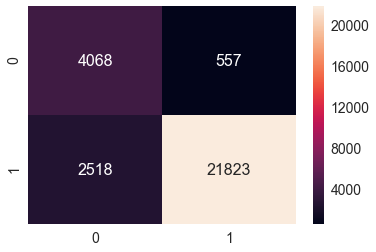

In [74]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [75]:
#top 10 positive features
all_features = tf_idf_vect.get_feature_names()
clf1=SGDClassifier(alpha=0.0001)
clf1.fit(X_train_tfidf,y_train)
weight=clf1.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
not
good
love
coffee
tea
like
one
flavor
best


In [76]:
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
worst
horrible
not worth
awful
return
waste money
not buy
threw
terrible
waste


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [114]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [115]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [116]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████████████████████████████████████████████| 8978/8978 [00:17<00:00, 508.41it/s]


(8978, 50)
[-0.22451501  0.32319835 -0.05526496  0.56428784 -0.41422456 -0.21908796
  0.10798722 -0.28313693  0.12236926  0.12535412  0.41788591 -0.10623649
 -0.25331543 -0.41423489 -0.42075427  0.01818938  0.01787659 -0.5948399
  0.34198462 -0.19584783 -0.06695439 -0.07814932  0.16046245 -0.35354994
  0.37976901  0.55823692  0.09537055 -0.98894901 -0.81603361 -0.16264968
  0.05035419  0.08512848 -0.0738451   0.22771003 -0.34963244  0.41684515
  0.25471601  0.16463409 -0.12760922  0.24471243  0.03522841  0.15749471
 -0.42578938  0.18841594 -0.10357776  0.45064282 -0.0063549   0.23762533
 -0.22983347  0.17650627]


In [117]:
#converting cv data to text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [118]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:08<00:00, 534.13it/s]


(4422, 50)
[-0.06082341 -0.16027423 -0.11781769  0.59853992 -0.40147693 -0.31502424
  0.17388766 -0.17828943  0.1879839  -0.09502401  0.3874762  -0.15092735
 -0.21880789 -0.51839637 -0.19104307 -0.05081413 -0.07454376 -0.62156154
  0.2515927  -0.50330483 -0.30943481  0.13922645  0.37422561 -0.23675229
  0.69329083  0.42359562 -0.23356989 -0.76647499 -0.4774208  -0.32449927
 -0.02132908  0.07350196 -0.11819225  0.01406646 -0.30879021  0.48454099
  0.41306982  0.39140388  0.0506024   0.31411261 -0.01901223 -0.12723354
 -0.49462752  0.32357    -0.21372675  0.50582239  0.03576883  0.23475359
 -0.1737203   0.11768374]


In [119]:
#Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [120]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 6600/6600 [00:11<00:00, 560.40it/s]


(6600, 50)
[-0.35141477  0.30207256  0.36489118  1.13556258 -0.48282944 -0.41154119
  0.32880604 -0.52255087 -0.36398829  0.2151373   0.49607645 -0.09836882
 -0.16435518 -0.64616171 -0.82077103  0.05751003  0.4985268  -0.23396362
 -0.09173773 -0.23723919 -0.01914052  0.20651749  0.14264282 -0.4015514
  0.78216137  0.86223091  0.40326742 -1.53755703 -1.52309212 -0.3971108
  0.39655958  0.13142623  0.08018153  0.47893411 -0.33054143  0.25254075
  0.27603369 -0.09961134 -0.56984769  0.65589104  0.04330845  0.18388952
 -1.22358029  0.1546187   0.09608887  0.61906624 -0.13153214 -0.2521649
 -0.1691256   0.03523409]


In [121]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
alphas=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clf2=SGDClassifier(loss='hinge', penalty='l2')
param_grid={'alpha':alphas}
grid = GridSearchCV(estimator = clf2,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(sent_vectors_train, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 0.01}
Accuracy on train data =  84.36177322343507


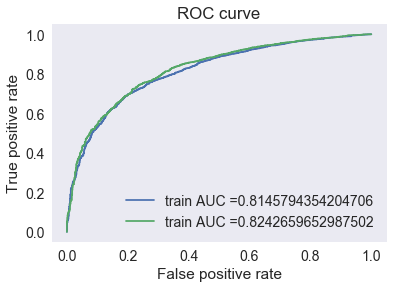

In [122]:
from sklearn.metrics import roc_curve, auc


clf2=SGDClassifier(loss='hinge', penalty='l2',alpha=0.001)
svm2=CalibratedClassifierCV(clf2, cv=3) #calibrated classifier cv for calculation of predic_proba
svm2.fit(sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svm2.predict_proba(sent_vectors_train)[:,1]
y_test_pred = svm2.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [123]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5569960435949346 for threshold 0.839
Train confusion matrix
[[1122  282]
 [2295 5279]]
Test confusion matrix
[[ 784  203]
 [1686 3927]]


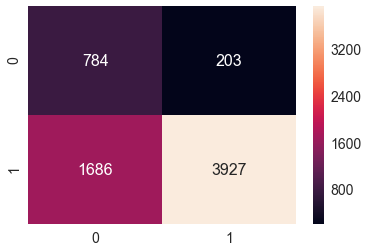

In [124]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [125]:
# Please write all the code with proper documentation

In [126]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [127]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 8978/8978 [01:43<00:00, 86.72it/s]


In [128]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [129]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:42<00:00, 78.55it/s]


In [130]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 6600/6600 [01:06<00:00, 99.40it/s]


In [132]:
alphas=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clf3=SGDClassifier(loss='hinge', penalty='l2')
param_grid={'alpha':alphas}
grid = GridSearchCV(estimator = clf3,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(tfidf_train_sent_vectors, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 0.001}
Accuracy on train data =  84.36177322343507


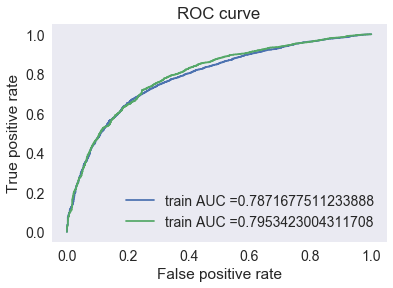

In [133]:
clf3=SGDClassifier(loss='hinge', penalty='l2',alpha=0.001)
svm3=CalibratedClassifierCV(clf3, cv=3) #calibrated classifier cv for calculation of predic_proba
svm3.fit(tfidf_train_sent_vectors,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svm3.predict_proba(tfidf_train_sent_vectors)[:,1]
y_test_pred = svm3.predict_proba(tfidf_test_sent_vectors)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [134]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5275799199089403 for threshold 0.837
Train confusion matrix
[[1090  314]
 [2427 5147]]
Test confusion matrix
[[ 756  231]
 [1776 3837]]


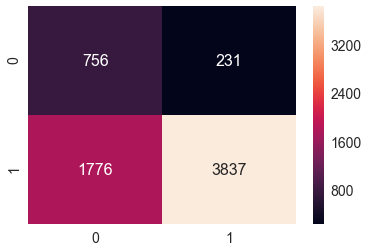

In [135]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [136]:
# Please write all the code with proper documentation
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import datasets
final['CleanedText']=preprocessed_reviews
print(final.shape)


(87773, 11)


In [137]:
labels = final['Score'].values

finals = final['CleanedText'].values

X = finals[0:20000]
Y = labels[0:20000]

In [138]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)


In [139]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=10, max_features=500)
vect.fit(X_train)
# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vect.transform(X_train)
X_cv_bow = vect.transform(X_cv)
X_test_bow = vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100) 


After vectorizations
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


In [140]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
c=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clfr=SVC(kernel='rbf')
param_grid={'C':c}
grid = GridSearchCV(estimator = clfr,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(X_train_bow, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'C': 100}
Accuracy on train data =  88.36043662285587


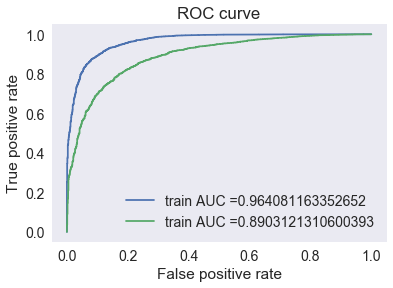

In [141]:
from sklearn.metrics import roc_curve, auc


clfr=SVC(C=100,kernel='rbf')
svmx=CalibratedClassifierCV(clfr, cv=3) #calibrated classifier cv for calculation of predic_proba
svmx.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svmx.predict_proba(X_train_bow)[:,1]
y_test_pred = svmx.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [142]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8041136937429734 for threshold 0.782
Train confusion matrix
[[1204  165]
 [ 652 6957]]
Test confusion matrix
[[ 747  264]
 [ 731 4858]]


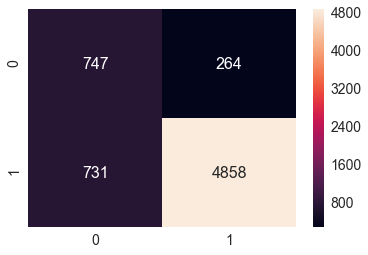

In [143]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [144]:
# Please write all the code with proper documentation
#splitting
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


In [145]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
c=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clfr1=SVC(kernel='rbf')
param_grid={'C':c}
grid = GridSearchCV(estimator = clfr1,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(X_train_bow, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'C': 100}
Accuracy on train data =  88.36043662285587


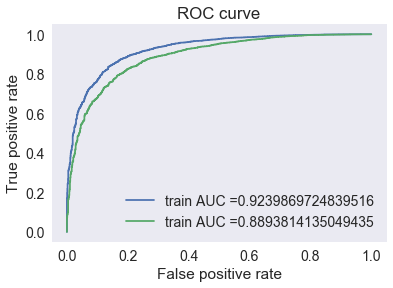

In [146]:
from sklearn.metrics import roc_curve, auc


clfr1=SVC(C=100,kernel='rbf')
svmx1=CalibratedClassifierCV(clfr1, cv=3) #calibrated classifier cv for calculation of predic_proba
svmx1.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svmx1.predict_proba(X_train_tfidf)[:,1]
y_test_pred = svmx1.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [147]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7217208755039133 for threshold 0.848
Train confusion matrix
[[1183  186]
 [1254 6355]]
Test confusion matrix
[[ 827  184]
 [1104 4485]]


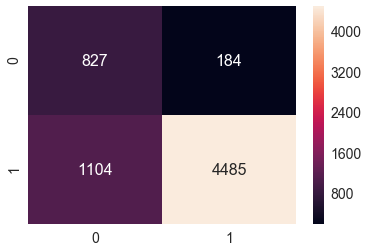

In [148]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [149]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [150]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [151]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████████████████████████████████████████████| 8978/8978 [00:14<00:00, 602.09it/s]


(8978, 50)
[-0.08816477  0.47931949 -0.19784994  0.66066134 -0.27319274 -0.2062667
  0.05950302 -0.15200672  0.13386018  0.24675231  0.68666252  0.07736196
 -0.53412728 -0.29003446 -0.37688039  0.0740077   0.05208525 -0.29406441
  0.22333254 -0.41564835 -0.20097756  0.20429813  0.09588394 -0.32016432
  0.2412113   0.5971355   0.201681   -0.75582842 -0.86301607 -0.1176374
 -0.31295251  0.34997952  0.09720548  0.70576421 -0.15740236  0.61324761
  0.04161164  0.37713231 -0.33427854  0.20330345 -0.01774494  0.15371284
 -0.65393827  0.24789565 -0.05120226  0.83013666 -0.0146831   0.37443567
 -0.00245327  0.08863075]


In [152]:
#converting cv data to text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [153]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:08<00:00, 528.32it/s]


(4422, 50)
[ 0.0562681   0.03601213 -0.35715528  0.679667   -0.2735205  -0.1741382
 -0.32006155  0.13082948  0.23885345 -0.00245475  0.65521843  0.05466517
 -0.4361332  -0.72392364 -0.27985602 -0.00401222 -0.1856975  -0.50196425
 -0.02463239 -0.55080593 -0.2916317   0.60267873  0.43448176 -0.33137428
  0.36887453  0.53557367  0.14480314 -0.80033604 -0.51030799  0.00138189
 -0.52450074  0.22191556 -0.0397718   0.8233881  -0.0862382   0.86979607
  0.1224395   0.33621109 -0.11211228  0.37513448  0.05551937 -0.03604737
 -0.70582948  0.72419869 -0.32522436  0.80884806  0.10163976  0.1221206
  0.13693827 -0.12128912]


In [154]:
#Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [155]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 6600/6600 [00:11<00:00, 581.44it/s]


(6600, 50)
[ 0.02208878  0.16721523  0.10037624  1.2430112  -0.18499182 -0.48466633
  0.40193992 -0.78651553 -0.02538035  0.11867429  0.21413926 -0.48341525
 -0.71474148 -0.66361877 -0.3212314   0.72530215  0.12672745 -0.7534969
  0.38777925 -0.82887224 -0.17852883 -0.12462844  0.24474628 -0.24567486
  0.57698285  0.47943391 -0.22008049 -0.7183283  -1.0201619  -0.26776084
 -0.3010148  -0.08172664 -0.11764207  0.31734332 -0.27127271  0.72743676
  0.0875244   0.40675248 -0.44450448  0.33730673  0.09107438 -0.0571644
 -0.4178624   0.36837286 -0.48682909  0.86181438  0.00794339 -0.00523253
  0.41836948  0.06101858]


In [156]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
c=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clfr2=SVC(kernel='rbf')
param_grid={'C':c}
grid = GridSearchCV(estimator = clfr2,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(sent_vectors_train, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'C': 10000}
Accuracy on train data =  86.16618400534641


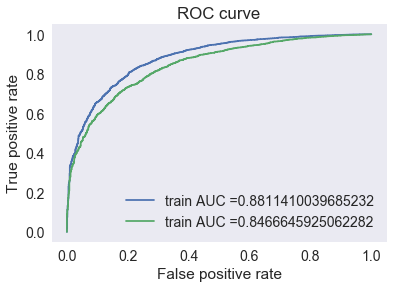

In [157]:
from sklearn.metrics import roc_curve, auc


clfr2=SVC(C=10000,kernel='rbf')
svmx2=CalibratedClassifierCV(clfr2, cv=3) #calibrated classifier cv for calculation of predic_proba
svmx2.fit(sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svmx2.predict_proba(sent_vectors_train)[:,1]
y_test_pred = svmx2.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [158]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6425607444031572 for threshold 0.822
Train confusion matrix
[[1088  281]
 [1457 6152]]
Test confusion matrix
[[ 760  251]
 [1303 4286]]


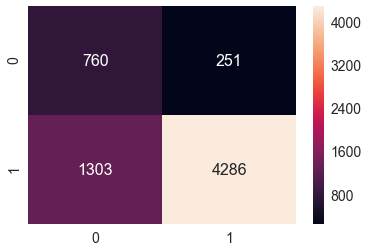

In [159]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [160]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [161]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 8978/8978 [01:43<00:00, 86.47it/s]


In [162]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [163]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:41<00:00, 106.67it/s]


In [164]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [165]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 6600/6600 [01:09<00:00, 94.89it/s]


In [166]:
from sklearn.svm import SVC
alphas=[0.0001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

clfr3=SVC(kernel='rbf')
param_grid={'C':c}
grid = GridSearchCV(estimator = clfr3,param_grid=param_grid ,cv =5,n_jobs = 5)
grid.fit(tfidf_train_sent_vectors, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'C': 10000}
Accuracy on train data =  85.208286923591


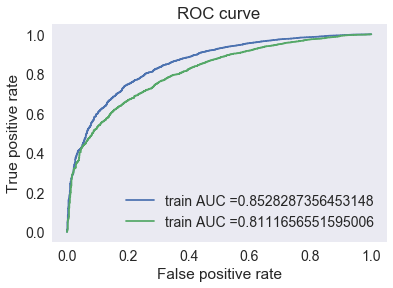

In [167]:
clfr3=SVC(C=10000,kernel='rbf')
svmx3=CalibratedClassifierCV(clfr3, cv=3) #calibrated classifier cv for calculation of predic_proba
svmx3.fit(sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svmx3.predict_proba(tfidf_train_sent_vectors)[:,1]
y_test_pred = svmx3.predict_proba(tfidf_test_sent_vectors)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid()
plt.show()

In [168]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5989600758242445 for threshold 0.838
Train confusion matrix
[[1100  269]
 [1937 5672]]
Test confusion matrix
[[ 756  255]
 [1611 3978]]


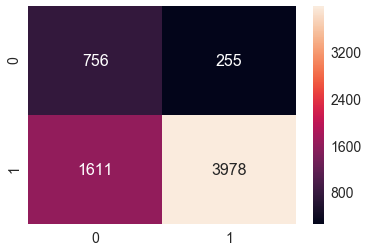

In [169]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [6] Conclusions

In [170]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "Train Accuracy"]

x.add_row(["BOW", "Linear SVM", 0.001, 0.97])
x.add_row(["TFIDF", "Linear SVM", 0.0001, 0.97])
x.add_row(["Avg W2V", "Linear SVM", 0.001, 0.81])
x.add_row(["TFIDF W2V", "Linear SVM", 0.001, 0.79])
x.add_row(["BOW", "RBF SVM", 100, 0.96])
x.add_row(["TFIDF", "RBF SVM", 100, 0.92])
x.add_row(["Avg W2V", "RBF SVM", 10000, 0.88])
x.add_row(["TFIDF W2V", "RBF SVM", 10000, 0.85])


print(x)

+------------+------------+-----------------+----------------+
| Vectorizer |   Model    | Hyper parameter | Train Accuracy |
+------------+------------+-----------------+----------------+
|    BOW     | Linear SVM |      0.001      |      0.97      |
|   TFIDF    | Linear SVM |      0.0001     |      0.97      |
|  Avg W2V   | Linear SVM |      0.001      |      0.81      |
| TFIDF W2V  | Linear SVM |      0.001      |      0.79      |
|    BOW     |  RBF SVM   |       100       |      0.96      |
|   TFIDF    |  RBF SVM   |       100       |      0.92      |
|  Avg W2V   |  RBF SVM   |      10000      |      0.88      |
| TFIDF W2V  |  RBF SVM   |      10000      |      0.85      |
+------------+------------+-----------------+----------------+
